In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.ticker import ScalarFormatter

In [2]:
df = pd.read_csv("../../results/vertex_simulation.csv")
df.head()

,m,block_1,block_2,effect_size,model,scalar_same,omni_same,mase_same,scalar_diff,omni_diff,...,mase_precision,scalar_f1,omni_f1,mase_f1,scalar_fp,omni_fp,mase_fp,scalar_tp,omni_tp,mase_tp
0,200,69,1,1,generate_graphs_1,0.0,0.047826,0.066667,0.0,1.00,...,0.010,0.0,0.424469,0.004567,0.0,0.047143,0.065714,0.0,0.014286,0.001143
1,200,69,1,1,generate_graphs_4,0.0,0.050000,0.052464,0.0,0.05,...,0.000,0.0,0.018190,0.002039,0.0,0.049286,0.051714,0.0,0.000714,0.000571
2,200,68,2,1,generate_graphs_1,0.0,0.055441,0.132206,0.0,1.00,...,0.030,0.0,0.550116,0.020155,0.0,0.053857,0.128429,0.0,0.028571,0.005143
3,200,68,2,1,generate_graphs_4,0.0,0.045441,0.055588,0.0,0.05,...,0.045,0.0,0.033833,0.008808,0.0,0.044143,0.054000,0.0,0.001429,0.001429
4,200,67,3,1,generate_graphs_1,0.0,0.043433,0.142537,0.0,1.00,...,0.080,0.0,0.698580,0.029891,0.0,0.041571,0.136429,0.0,0.042857,0.008000


In [3]:
block_2s = np.arange(1, 70)
block_1s = 70 - block_2s

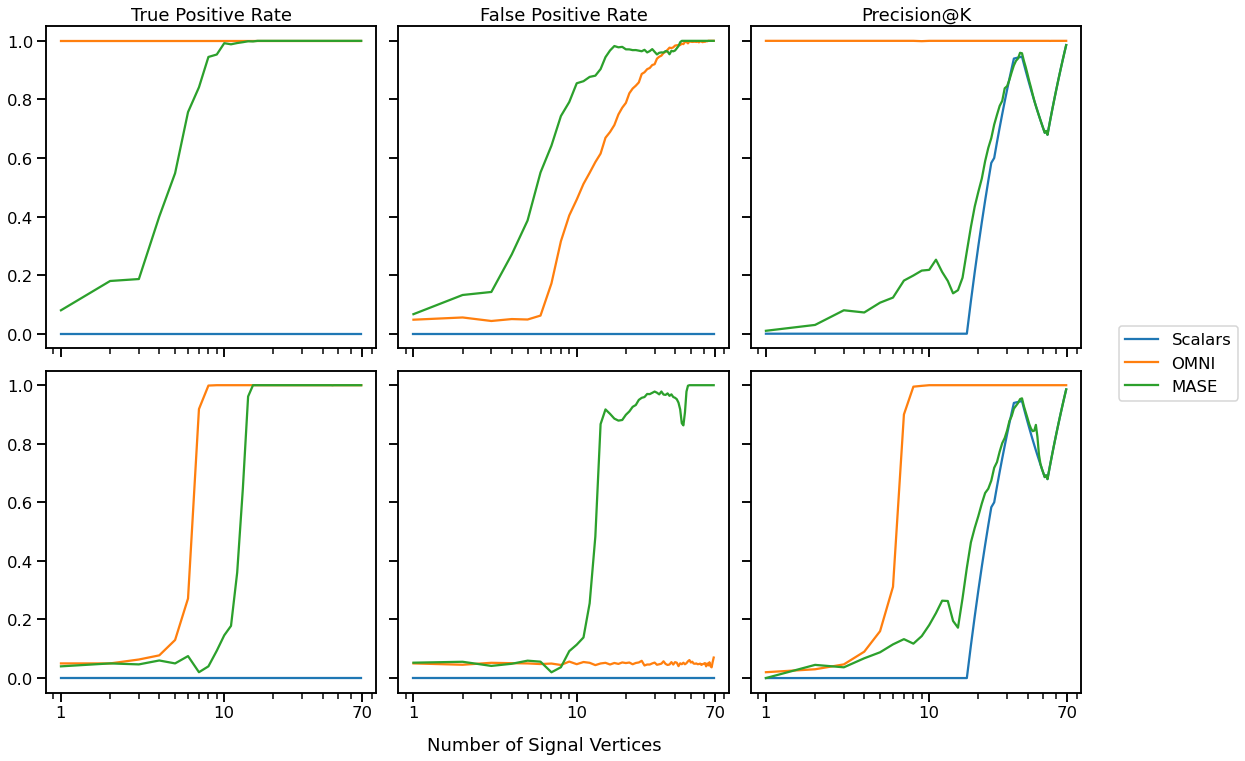

In [4]:
sns.set_context("talk")

fig, ax = plt.subplots(
    ncols=3,
    nrows=2,
    sharex=True,
    sharey=True,
    figsize=(15, 10),
    constrained_layout=True,
)


for i, model in enumerate(np.unique(df.model)):
    tmp = df[df.model == model]

    sns.lineplot(
        tmp.block_2, tmp.scalar_tp * 70 / block_2s, ax=ax[i, 0], label="Scalars"
    )
    sns.lineplot(tmp.block_2, tmp.omni_tp * 70 / block_2s, ax=ax[i, 0], label="OMNI")
    sns.lineplot(tmp.block_2, tmp.mase_tp * 70 / block_2s, ax=ax[i, 0], label="MASE")

    sns.lineplot(tmp.block_2, tmp.scalar_fp * 70 / block_1s, ax=ax[i, 1])
    sns.lineplot(tmp.block_2, tmp.omni_fp * 70 / block_1s, ax=ax[i, 1])
    sns.lineplot(tmp.block_2, tmp.mase_fp * 70 / block_1s, ax=ax[i, 1])

    sns.lineplot(tmp.block_2, tmp.scalar_precision, ax=ax[i, 2])
    sns.lineplot(tmp.block_2, tmp.omni_precision, ax=ax[i, 2])
    sns.lineplot(tmp.block_2, tmp.mase_precision, ax=ax[i, 2])

    for idx in range(3):
        ax[i, idx].set_ylabel("")
        ax[i, idx].set_xlabel("")

    if i == 0:
        titles = ["True Positive Rate", "False Positive Rate", "Precision@K"]
        for j, title in enumerate(titles):
            ax[0, j].set_title(title)

    handles, labels = ax[i, 0].get_legend_handles_labels()

    ax[i, 0].get_legend().remove()

legend = fig.legend(
    handles,
    labels,
    ncol=1,
    loc="center right",
    bbox_to_anchor=(1.15, 0.5),
    bbox_transform=plt.gcf().transFigure,
)

ax[0, 0].set_xscale("log")
ax[0, 0].set_xticks([1, 10, 70])
ax[0, 0].get_xaxis().set_major_formatter(ScalarFormatter())

fig.text(0.5, -0.03, "Number of Signal Vertices", va="center", ha="center")
plt.show()